In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import requests
import zipfile
import os
from PIL import Image
from io import BytesIO
from sklearn.model_selection import train_test_split


# Costruzione del modello generatore
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128 * 16 * 16, activation="relu", input_dim=100))
    model.add(layers.Reshape((16, 16, 128)))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))
    model.add(layers.Conv2D(1, kernel_size=3, padding="same"))
    model.add(layers.Activation("tanh"))
    return model

# Costruzione del modello discriminatore
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=(64, 64, 1), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Funzione per caricare e preprocessare le immagini
def load_images(image_folder, image_size=(64, 64)):
    images = []
    for filename in os.listdir(image_folder):
        img = Image.open(os.path.join(image_folder, filename)).convert('L')
        img = img.resize(image_size)
        img = np.array(img)
        img = (img - 127.5) / 127.5
        images.append(img)
    return np.expand_dims(np.array(images), axis=-1)


train_images = load_images(os.path.join(os.getcwd(), "train/sea"))
test_images = load_images(os.path.join(os.getcwd(), "test/sea"))






# Costruisci e compila la GAN
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
discriminator.trainable = False
gan_output = discriminator(generated_image)
gan = tf.keras.models.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Funzione di addestramento della GAN
def train_gan(epochs, batch_size=128):
    for epoch in range(epochs):
        # Addestramento del discriminatore
        idx = np.random.randint(0, train_images.shape[0], batch_size)
        real_images = train_images[idx]
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(generated_images, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Addestramento del generatore
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)
        g_loss = gan.train_on_batch(noise, valid_y)

        # Stampa dei progressi
        print(f"{epoch + 1}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

# Addestra la GAN
train_gan(epochs=10000, batch_size=32)


In [22]:
import os
import numpy as np
from PIL import Image


def load_images(image_folder, image_size=(128, 128)):
    images = []
    for filename in os.listdir(image_folder):
        img = Image.open(os.path.join(image_folder, filename)).convert('L')
        img = img.resize(image_size)
        img = np.array(img)
        img = (img - 127.5) / 127.5
        images.append(img)
    return np.expand_dims(np.array(images), axis=-1)


images = load_images(os.path.join(os.getcwd(), "train/sea"))

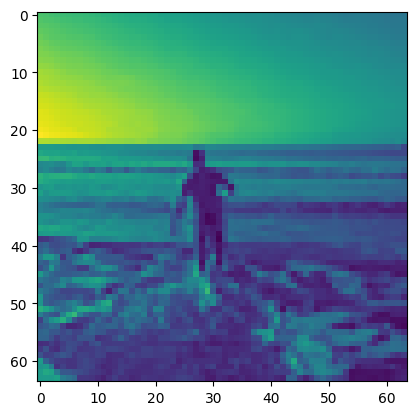

In [23]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(images[1])
plt.show()